## Item-11

### Apply and Evaluate Model to Test Set

#### Objective:
Run predictions for your test set and evaluate logistic regression model accuracy
#### Steps:
* Switch feature matrix to test set
* Predict
* Compute percentage of agreement

In [155]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

In [156]:
df=pd.read_csv(r"C:\Users\ayber\OneDrive\Masaüstü\ML\Data\external\Fatigue_data.csv").copy()
target='Fatigue'

X = df.drop(columns=['Sl. No.', target]).copy()
y_reg = df[target].to_numpy()
y = (y_reg > 500).astype(int)     # 1=good, 0=bad

pd.Series(y).value_counts()

1    233
0    204
Name: count, dtype: int64

In [157]:
# 60/20/20 with stratification (important for class balance)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

In [158]:
# --Helpers for future use--
def fit_and_print_clf(p, model_name, thr=0.5, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    p.fit(X_train, y_train)

    # feature count before the estimator
    Z_train = p[:-1].transform(X_train)
    n_features = Z_train.shape[1]

    # probabilities -> labels at threshold
    proba_tr = p.predict_proba(X_train)[:, 1]
    proba_te = p.predict_proba(X_test)[:, 1]
    yhat_tr  = (proba_tr >= thr).astype(int)
    yhat_te  = (proba_te >= thr).astype(int)

    # metrics
    acc_tr = accuracy_score(y_train, yhat_tr) * 100.0
    acc_te = accuracy_score(y_test,  yhat_te) * 100.0
    auc_tr = roc_auc_score(y_train, proba_tr)
    auc_te = roc_auc_score(y_test,  proba_te)

    print("Model Name ->", model_name)
    print("Feature count:", n_features)
    print(f"Agreement (train): {acc_tr:.2f}% | AUC: {auc_tr:.3f}")
    print(f"Agreement (test):  {acc_te:.2f}% | AUC: {auc_te:.3f}")
    print("Confusion matrix (test):\n", confusion_matrix(y_test, yhat_te))

In [159]:
p1= Pipeline([
    ("poly",  PolynomialFeatures(degree=2, include_bias=False)),
    ("scale", StandardScaler()),
    ("clf",   LogisticRegressionCV(
        Cs=np.logspace(-2, 3, 13),
        cv=5,
        max_iter=10000,
        scoring="roc_auc",
        n_jobs=-1,
        refit=True
    ))
])

fit_and_print_clf(p1, model_name="Logistic Regression")
print("Best C:", p1.named_steps["clf"].C_[0])

Model Name -> Logistic Regression
Feature count: 350
Agreement (train): 100.00% | AUC: 1.000
Agreement (test):  89.77% | AUC: 0.979
Confusion matrix (test):
 [[36  5]
 [ 4 43]]
Best C: 1.2115276586285888


Percentage Agreement is **89.77%**

## Item-12

### Improve Model Accuracy

#### Objective:
Try to improve test set agreement percentage
#### Steps:
 * Create/select/exclude features
 * Train + Perform logistic regression
 * Compute percentage of agreement and find best one you can

In [160]:
#Feature exclusion and parameter tuning done on the previous model
p2= Pipeline([
    ("scale", StandardScaler()),
    ("clf",   LogisticRegressionCV(
        Cs=np.logspace(-2, 3, 26),
        cv=5,
        penalty="l1",
        solver="saga",
        max_iter=10000,
        scoring="roc_auc",
        n_jobs=-1,
        refit=True
    ))
])

fit_and_print_clf(p2, model_name="Logistic Regression with ")
print("Best C:", p2.named_steps["clf"].C_[0])

Model Name -> Logistic Regression with 
Feature count: 25
Agreement (train): 96.93% | AUC: 0.996
Agreement (test):  93.18% | AUC: 0.972
Confusion matrix (test):
 [[38  3]
 [ 3 44]]
Best C: 2.5118864315095824


* Previous Percentage Agreement was **89.77%**
* Improved Models Agreement is **93.18%**

## Item-13

### Use RR on your dataset

#### Objective:
Compare Ridge Regression result to your previous models
#### Steps:
 * Create/Select features similar to before
 * Perform ridge regression on these using scikit-learn
 * Compare to the weights you get in your regular regression

In [161]:
from sklearn.linear_model import RidgeCV, LinearRegression

In [162]:
X = df.drop(columns=['Sl. No.', target]).copy()
y = df['Fatigue'].to_numpy()
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val,  y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

In [163]:
def rmse(y_true, y_pred):
    from sklearn.metrics import mean_squared_error
    return mean_squared_error(y_true, y_pred) ** 0.5

def fit_and_print(p, model_name, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, X_val=X_val, y_val=y_val):
    p.fit(X_train,y_train)
    train_preds= p.predict(X_train)
    validation_preds = p.predict(X_val)
    test_preds= p.predict(X_test)
    
    
    Z_train = p[:-1].transform(X_train)
    n_features = Z_train.shape[1]
    print("Model Name -> " + str(model_name))
    print("Feature count " + str(n_features))
    print("Training error: " + str(rmse(train_preds, y_train)))
    print("Validation error: " + str(rmse(validation_preds, y_val)))
    print("Testing error: " + str(rmse(test_preds, y_test)) + "\n")

In [164]:
p3 = Pipeline([
    ("poly",  PolynomialFeatures(degree=2, include_bias=False)),
    ("scale", StandardScaler(with_mean=True, with_std=True)),
    ("ridge", RidgeCV(alphas=np.logspace(-4, 4, 33), cv=5))
])

fit_and_print(p3, model_name="Ridge Regression")
print("Ridge alpha:", p3.named_steps["ridge"].alpha_)

Model Name -> Ridge Regression
Feature count 350
Training error: 17.612567878994412
Validation error: 26.777701024099567
Testing error: 30.5408097784356

Ridge alpha: 10.0


In [165]:
p4 = Pipeline([
    ("poly",  PolynomialFeatures(degree=2, include_bias=False)),
    ("scale", StandardScaler(with_mean=True, with_std=True)),
    ("ols",   LinearRegression())
])  

fit_and_print(p4, model_name="Regular Linear Regression")

Model Name -> Regular Linear Regression
Feature count 350
Training error: 6.354231662215995
Validation error: 213.37353878450864
Testing error: 389.6138200719838



In [166]:
base_names = getattr(X_train, "columns", np.array([f"x{i}" for i in range(X_train.shape[1])]))
poly = p3.named_steps["poly"]
feat_names = poly.get_feature_names_out(base_names)  

In [167]:
# Undo StandardScaler to make weights comparable
def unscale_coefficients(pipe):
    steps = pipe.named_steps
    scaler = steps["scale"]
    est_key = [k for k in steps.keys() if k not in ("poly","scale")][0]
    est = steps[est_key]

    w = np.ravel(est.coef_)
    b = est.intercept_
    sigma = scaler.scale_
    mu    = scaler.mean_

    w_unscaled = w / sigma
    b_unscaled = b - np.sum(w * mu / sigma)
    return w_unscaled, b_unscaled

w_ridge, b_ridge = unscale_coefficients(p3)
w_ols,   b_ols   = unscale_coefficients(p4)


In [168]:
# Build comparison table
coef_df = pd.DataFrame({
    "feature": feat_names,
    "ridge_w": w_ridge,
    "ols_w":   w_ols
})

coef_df["abs_ridge"] = np.abs(coef_df["ridge_w"].values)
coef_df["abs_ols"]   = np.abs(coef_df["ols_w"].values)
coef_df["diff"]      = coef_df["ridge_w"].values - coef_df["ols_w"].values
coef_df["abs_diff"]  = np.abs(coef_df["diff"].values)

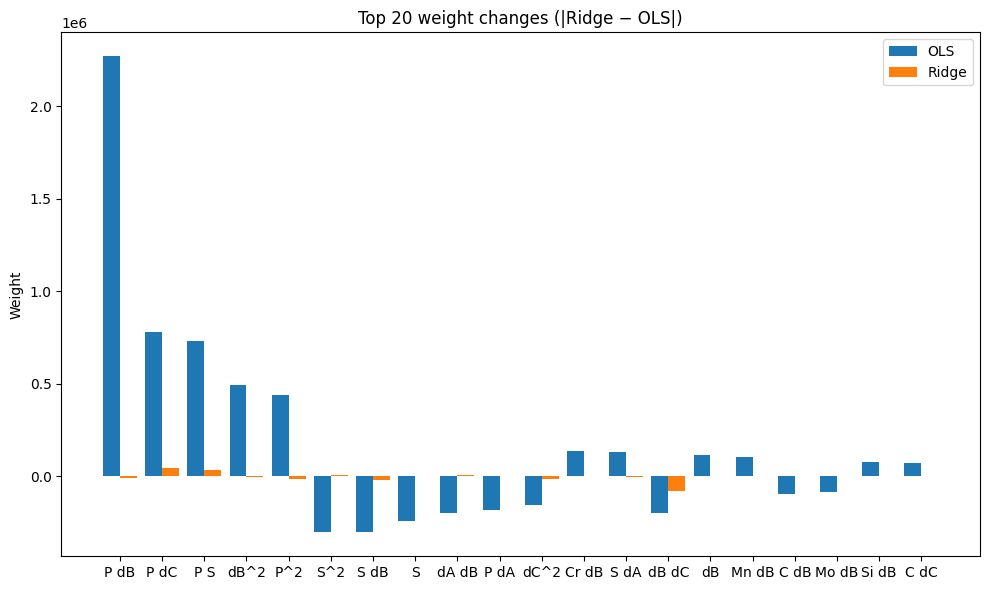

In [169]:
K = 20 
topK = coef_df.sort_values("abs_diff", ascending=False).head(K).copy()

plt.figure(figsize=(10,6))
positions = np.arange(len(topK))
bar_width = 0.4
plt.bar(positions - bar_width/2, topK["ols_w"], width=0.4, label="OLS")
plt.bar(positions + bar_width/2, topK["ridge_w"], width=0.4, label="Ridge")
plt.xticks(positions, topK["feature"])
plt.ylabel("Weight")
plt.title(f"Top {K} weight changes (|Ridge − OLS|)")
plt.legend()
plt.tight_layout()
plt.show()

## Item-14

### Use KRR on your dataset

#### Objective:
* Compare Kernel Ridge Regression result to your previous models.

#### Steps:
* Create/Select features similar to before
* Perform kernel ridge regression on these using sciki-learn
* Test if your model is overfit or not

In [170]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

In [171]:
pipe = Pipeline([("scale", StandardScaler()),
                 ("krr", KernelRidge(kernel="rbf"))])

param_grid = {
    "krr__alpha": np.logspace(-4, 2, 10),
    "krr__gamma": np.logspace(-3, 2, 6)
}

cv5 = KFold(n_splits=5, shuffle=True, random_state=2)
gs = GridSearchCV(pipe, param_grid, scoring="neg_root_mean_squared_error",
                  cv=cv5, n_jobs=-1, refit=True)
gs.fit(X_train, y_train)

# Eval on train/val/test to check overfit
pred_tr  = gs.predict(X_train)
pred_val = gs.predict(X_val)
pred_te  = gs.predict(X_test)

print("Best params:", gs.best_params_)
print("RMSE (train/val/test):",
      f"{rmse(y_train,pred_tr):.4f} / {rmse(y_val,pred_val):.4f} / {rmse(y_test,pred_te):.4f}")
# Quick overfit check: train << val/test suggests overfit

Best params: {'krr__alpha': np.float64(0.002154434690031882), 'krr__gamma': np.float64(0.01)}
RMSE (train/val/test): 10.7943 / 23.2921 / 27.7127


In [172]:
# Simple learning curve
sizes = np.linspace(0.2, 1.0, 5)
lc = []
for s in sizes:
    n = int(len(X_train)*s)
    gs.fit(X_train[:n], y_train[:n])
    lc.append([s, rmse(y_train[:n], gs.predict(X_train[:n])), rmse(y_val, gs.predict(X_val))])
print("\n Learning curve (KRR)")
print(f"{'frac':>6}  {'rmse_train':>11}  {'rmse_val':>9}")
for f, rt, rv in lc:
    print(f"{float(f):6.2f}  {float(rt):11.3f}  {float(rv):9.3f}")


 Learning curve (KRR)
  frac   rmse_train   rmse_val
  0.20       10.956     32.442
  0.40       14.881     27.690
  0.60       14.872     24.428
  0.80       16.319     22.917
  1.00       10.794     23.292


Yes—there’s **noticeable overfitting**: train RMSE ≈10.8 vs val ≈23.3, with a persistent gap across sizes.

Rule of thumb: if val ≈ 1.5× train → mild; ≥2× → noticeable overfit. We’re around that threshold, so we should dial back capacity (↑α, ↓γ) or reduce features

## Item-15

### Use KRR on your dataset

#### Objective:
* Compare training times for the different models

#### Steps:
 * Evaluate time that it takes to perform hyper parameter optimization for LASSO, RR, 
KRR
 * Determine this for three different training set sizes
 * Plot the results

In [173]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV, KFold
import time

In [174]:
# Define models and parameter grids
models = {
    'LASSO': (
        Pipeline([('scale', StandardScaler()), ('lasso', Lasso(max_iter=10000, tol=1e-4))]),
        {'lasso__alpha': np.logspace(-4, 2, 10)}
    ),
    'Ridge': (
        Pipeline([('scale', StandardScaler()), ('ridge', Ridge())]),
        {'ridge__alpha': np.logspace(-4, 2, 10)}
    ),
    'KRR': (
        Pipeline([('scale', StandardScaler()), ('krr', KernelRidge(kernel='rbf'))]),
        {'krr__alpha': np.logspace(-4, 2, 10), 'krr__gamma': np.logspace(-3, 2, 6)}
    )
}

cv = 5           # 5-fold cross validation
n_jobs = -1      
train_fracs = [0.4, 0.6, 0.8]

In [175]:
def time_grid_search(estimator, param_grid, X_sub, y_sub):
    gs = GridSearchCV(estimator, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, refit=True)
    t0 = time.perf_counter()
    gs.fit(X_sub, y_sub)
    t1 = time.perf_counter()
    return gs, t1 - t0

In [176]:
results = []

for frac in train_fracs:
    X_sub, _, y_sub, _ = train_test_split(X, y, train_size=frac, random_state=2)
    for name, (pipe, grid) in models.items():
        _, elapsed = time_grid_search(pipe, grid, X_sub, y_sub)
        results.append({'model': name, 'train_frac': frac, 'seconds': elapsed})

results_df = pd.DataFrame(results).sort_values(['train_frac', 'model']).reset_index(drop=True)
print(results_df)

c:\Users\ayber\OneDrive\Masaüstü\ML\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.466e+04, tolerance: 6.348e+02
  model = cd_fast.enet_coordinate_descent(


   model  train_frac   seconds
0    KRR         0.4  0.226796
1  LASSO         0.4  0.156200
2  Ridge         0.4  0.062976
3    KRR         0.6  0.249352
4  LASSO         0.6  0.150201
5  Ridge         0.6  0.062982
6    KRR         0.8  0.308286
7  LASSO         0.8  0.164469
8  Ridge         0.8  0.063598


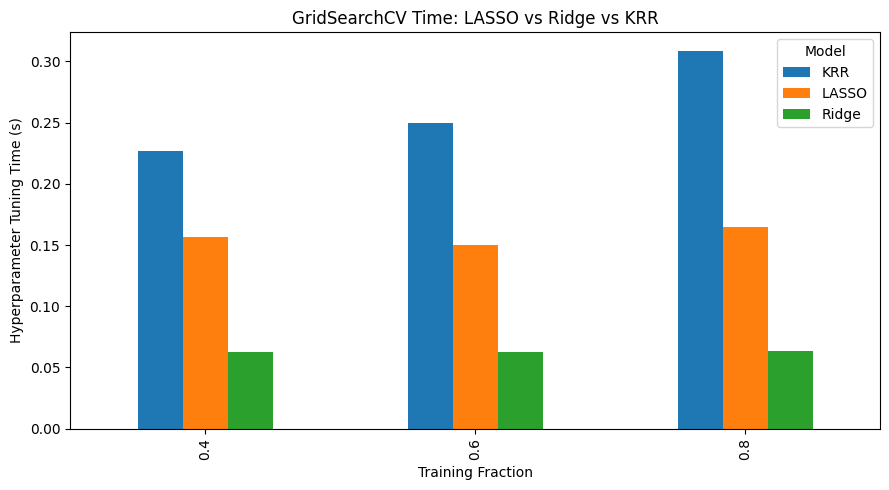

In [177]:
# Plot grouped bar chart of tuning time
pivot = results_df.pivot(index='train_frac', columns='model', values='seconds')
ax = pivot.plot(kind='bar', figsize=(9,5))
ax.set_xlabel('Training Fraction')
ax.set_ylabel('Hyperparameter Tuning Time (s)')
ax.set_title('GridSearchCV Time: LASSO vs Ridge vs KRR')
ax.legend(title='Model')
plt.tight_layout()
plt.show()

As we can see from the graph Kernel ridge takes more time than orhers since it requires optimization of 2 parameter rather than 1. Lasso is the second and Ridge takes the less time.

## Item-16

### Use KNN on your dataset

#### Objective:
Compare KNN to your previous models

#### Steps:
 * Create/Select features similar to before
 * Perform KNN on these using scikit-learn
 * Use cross validation to determine k and avoid 
overfit/underfit
 * Plot predictions together with other models

In [178]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_regression

In [179]:
target='Fatigue'
X = df.drop(columns=['Sl. No.', target]).copy()
y = df[target].copy()
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, shuffle=True, random_state=42)

In [180]:
pipe = Pipeline([("sel", SelectKBest(score_func=mutual_info_regression)),  #Select features
                 ("scaler", StandardScaler()),                             #Normalize
                 ("knn", KNeighborsRegressor())])                          #Perform KNN

param_grid = {"sel__k": [5, 7, 9, 11],
              "knn__n_neighbors":list(range(1, 21, 1)),                     #Try different k values
              "knn__weights":["uniform","distance"],  
              "knn__p":[1,2]}                                               # Manhattan, Euclidean

cv = GridSearchCV(pipe, param_grid, scoring="neg_root_mean_squared_error",
                  cv=KFold(n_splits=5, shuffle=True, random_state=2), n_jobs=-1)

cv.fit(X_train, y_train)
pred_tr, pred_val, pred_te = cv.predict(X_train), cv.predict(X_val), cv.predict(X_test)

print("Best:", cv.best_params_)
print("RMSE",
f"\n Train: {rmse(y_train,pred_tr):.4f}\n Validation: {rmse(y_val,pred_val):.4f}\n Test: {rmse(y_test,pred_te):.4f}")

Best: {'knn__n_neighbors': 4, 'knn__p': 1, 'knn__weights': 'distance', 'sel__k': 7}
RMSE 
 Train: 9.0799
 Validation: 30.9781
 Test: 31.5520


Our validation result is not much less than test result, so **no overfitting**

In [181]:
models = {
    'LASSO': (
        Pipeline([('scale', StandardScaler()), ('lasso', Lasso(max_iter=10000, tol=1e-4))]),
        {'lasso__alpha': np.logspace(-4, 2, 10)}
    ),
    'Ridge': (
        Pipeline([('scale', StandardScaler()), ('ridge', Ridge())]),
        {'ridge__alpha': np.logspace(-4, 2, 10)}
    ),
    'KRR': (
        Pipeline([('scale', StandardScaler()), ('krr', KernelRidge(kernel='rbf'))]),
        {'krr__alpha': np.logspace(-4, 2, 10), 'krr__gamma': np.logspace(-3, 2, 6)}
    ),
    'KNN': (
        Pipeline([("sel", SelectKBest(score_func=mutual_info_regression)),('scale', StandardScaler()), ('knn', KNeighborsRegressor())]),
        {
            "sel__k": [7],                   #Since we found best parameters previously
            'knn__n_neighbors': [4],  
            'knn__weights': ['distance'],
            'knn__p': [1],                          
        }
    )
}
preds = {}
cv = KFold(n_splits=5, shuffle=True, random_state=2)
scoring = 'neg_mean_squared_error'
n_jobs = -1

for name, (pipe, grid) in models.items():
    gs = GridSearchCV(pipe, grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=n_jobs, refit=True, verbose=0)
    gs.fit(X_train, y_train)
    best = gs.best_estimator_
    y_pred = best.predict(X_test)
    preds[name] = y_pred

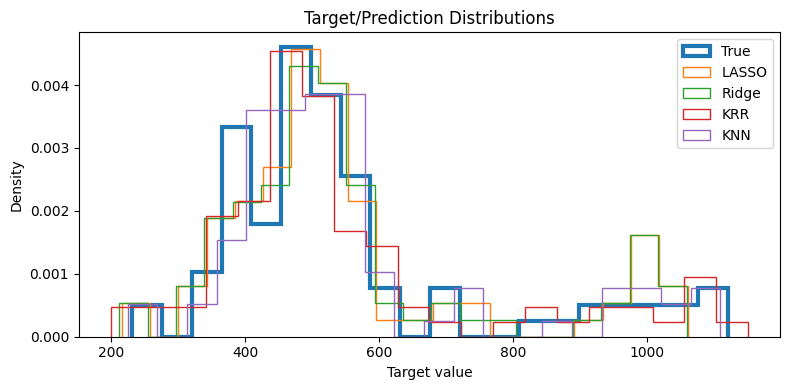

In [182]:
all_vals = [y_test] + list(preds.values())

plt.figure(figsize=(8,4))
plt.hist(y_test, bins=20, density=True, histtype="step", linewidth=3, label="True")
for name, y_pred in preds.items():
    plt.hist(y_pred, bins=20, density=True, histtype="step", linewidth=1, label=name)
plt.title("Target/Prediction Distributions")
plt.xlabel("Target value")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()